In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install torch==1.9.0

In [ ]:
import torch
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
import scipy.ndimage
import torch.nn as nn
import torchvision
from skimage import transform
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE

# image

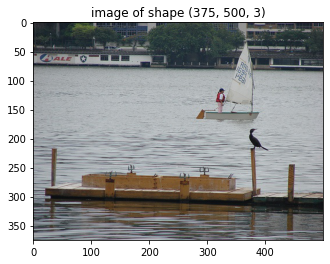

In [ ]:
img = np.array(Image.open('2007_002403.jpg'))
img = (img / float(img.max())).astype(np.float32)
plt.imshow(img)
plt.title('image of shape {}'.format(img.shape))
plt.show()

# Preprocess

## spatial graph 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


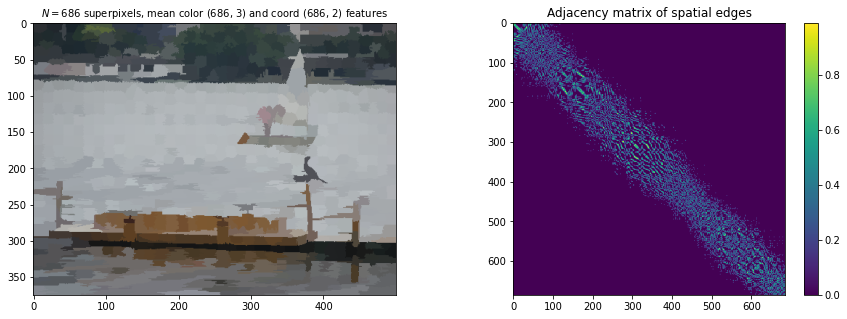

In [ ]:
knn_graph = 32  # maximum number of neighbors for each node

def sparsify_graph(A, knn_graph):
    if knn_graph is not None and knn_graph < A.shape[0]:
        idx = np.argsort(A, axis=0)[:-knn_graph, :]
        np.put_along_axis(A, idx, 0, axis=0)
        idx = np.argsort(A, axis=1)[:, :-knn_graph]
        np.put_along_axis(A, idx, 0, axis=1)
    return A    
        
def spatial_graph(coord, img_size, knn_graph=32):
    coord = coord / np.array(img_size, np.float)
    dist = cdist(coord, coord)
    sigma = 0.1 * np.pi
    A = np.exp(- dist / sigma**2)
    A[np.diag_indices_from(A)] = 0  # remove self-loops
    sparsify_graph(A, knn_graph)
    return A  # adjacency matrix (edges)

def visualize_superpixels(avg_values, superpixels):
    n_ch = avg_values.shape[1]
    img_sp = np.zeros((*superpixels.shape, n_ch))
    for sp in np.unique(superpixels):
        mask = superpixels == sp
        for c in range(n_ch):
            img_sp[:, :, c][mask] = avg_values[sp, c]
    return img_sp

def superpixel_features(img, superpixels):
    # mean of RGB values
    n_sp = len(np.unique(superpixels))
    n_ch = img.shape[2]
    avg_values = np.zeros((n_sp, n_ch))
    coord = np.zeros((n_sp, 2))
    masks = []
    for sp in np.unique(superpixels):
        mask = superpixels == sp
        for c in range(n_ch):
            avg_values[sp, c] = np.mean(img[:, :, c][mask])         
        coord[sp] = np.array(scipy.ndimage.measurements.center_of_mass(mask))  # row, col
        masks.append(mask)
    return avg_values, coord, masks



superpixels = slic(img, n_segments=1000)
avg_values, coord, masks = superpixel_features(img, superpixels)
A_spatial = spatial_graph(coord, img.shape[:2], knn_graph=knn_graph)  # keep only 16 neighbors for each node
img_sp = visualize_superpixels(avg_values, superpixels)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img_sp)
plt.title('$N=${} superpixels, mean color {} and coord {} features'.format(len(np.unique(superpixels)), 
                                                                           avg_values.shape,
                                                                           coord.shape), fontsize=10)
plt.subplot(122)
plt.imshow(A_spatial ** 0.2)
plt.colorbar()
plt.title('Adjacency matrix of spatial edges')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


(686, 256)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


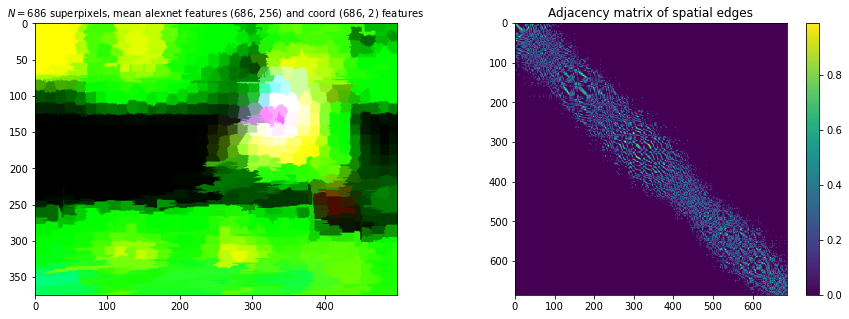

In [ ]:
alexnet = torchvision.models.alexnet(pretrained = True)

def superpixel_Alexnet_features(img, superpixels, alexnet):
    n_sp = len(np.unique(superpixels))
    img_alexnet = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
    feature_alexnet = alexnet.features(img_alexnet)[0]
    n_ch = feature_alexnet.shape[0]
    
    feature_alexnet_resized =transform.resize(feature_alexnet.data.numpy(), (n_ch, img.shape[0], img.shape[1]))
    avg_values = np.zeros((n_sp, n_ch))
    coord = np.zeros((n_sp, 2))
    masks = []
    for sp in np.unique(superpixels):
        mask = superpixels == sp
        for c in range(n_ch):
            avg_values[sp, c] = np.mean(feature_alexnet_resized[c, :, :][mask])         
        coord[sp] = np.array(scipy.ndimage.measurements.center_of_mass(mask))  # row, col
        masks.append(mask)
    return avg_values, coord, masks

superpixels = slic(img, n_segments=1000)
avg_values, coord, masks = superpixel_Alexnet_features(img, superpixels, alexnet)
print(avg_values.shape)
A_spatial = spatial_graph(coord, img.shape[:2], knn_graph=knn_graph)  # keep only 16 neighbors for each node
img_sp = visualize_superpixels(avg_values, superpixels)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img_sp[:,:,200:203])
plt.title('$N=${} superpixels, mean alexnet features {} and coord {} features'.format(len(np.unique(superpixels)), 
                                                                           avg_values.shape,
                                                                           coord.shape), fontsize=10)
plt.subplot(122)
plt.imshow(A_spatial ** 0.2)
plt.colorbar()
plt.title('Adjacency matrix of spatial edges')
plt.show()

###  Alexnet test


In [ ]:
alexnet = torchvision.models.alexnet(pretrained = True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print(feature_img.shape[1])

256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 333, 500])
torch.Size([1, 256, 9, 14])


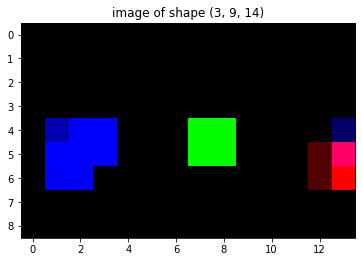

In [ ]:
img_alexnet = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
feature_img = alexnet.features(img_alexnet)
print(img_alexnet.shape)
print(feature_img.shape)
feature_alexnet = feature_img[0]
plt.imshow(feature_alexnet[0:3,:,:].squeeze().permute(1, 2, 0).data.numpy())
plt.title('image of shape {}'.format(tuple(feature_alexnet[0:3,:,:].shape)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


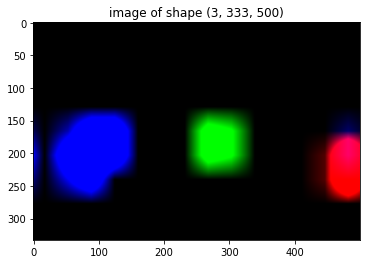

In [ ]:
from skimage import transform,data
feature_alexnet_resized =torch.tensor(transform.resize(feature_alexnet.data.numpy(), (256, 333, 500)))
plt.imshow(feature_alexnet_resized[0:3,:,:].squeeze().permute(1, 2, 0).data.numpy())
plt.title('image of shape {}'.format(tuple(feature_alexnet_resized[0:3,:,:].shape)))
plt.show()

In [ ]:
print(avg_values.shape)
print(avg_values)
print(coord)

(898, 3)
[[0.24223661 0.28967071 0.25957409]
 [0.47283497 0.49857029 0.50612742]
 [0.69494176 0.70426255 0.71949422]
 ...
 [0.58649236 0.54643637 0.5056023 ]
 [0.65315121 0.60112041 0.54177177]
 [0.63816267 0.5948438  0.53050113]]
[[  6.35885167   7.95215311]
 [  5.85416667  23.86458333]
 [  2.84782609  31.44202899]
 ...
 [328.25396825 492.35714286]
 [328.59821429 123.63392857]
 [328.65740741 188.62962963]]


In [ ]:
print(superpixels.shape)
print(superpixels)
print(A_spatial)
print(A_spatial.shape)
print(coord)

(333, 500)
[[  0   0   0 ...  32  32  32]
 [  0   0   0 ...  32  32  32]
 [  0   0   0 ...  32  32  32]
 ...
 [887 887 887 ... 895 895 895]
 [887 887 887 ... 895 895 895]
 [887 887 887 ... 895 895 895]]
[[0.         0.72410513 0.61394807 ... 0.         0.         0.        ]
 [0.72410513 0.         0.83632957 ... 0.         0.         0.        ]
 [0.61394807 0.83632957 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.26791393]
 [0.         0.         0.         ... 0.         0.26791393 0.        ]]
(898, 898)
[[  6.35885167   7.95215311]
 [  5.85416667  23.86458333]
 [  2.84782609  31.44202899]
 ...
 [328.25396825 492.35714286]
 [328.59821429 123.63392857]
 [328.65740741 188.62962963]]


In [ ]:
len(np.unique(superpixels))
superpixels
A_spatial


array([[0.        , 0.72410513, 0.61394807, ..., 0.        , 0.        ,
        0.        ],
       [0.72410513, 0.        , 0.83632957, ..., 0.        , 0.        ,
        0.        ],
       [0.61394807, 0.83632957, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.26791393],
       [0.        , 0.        , 0.        , ..., 0.        , 0.26791393,
        0.        ]])

# 4. GAE

In [ ]:
# compute the number of trainable parameters
num_params = lambda model: np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()])

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [ ]:
def Adj2index(A):
  nodeA = []
  nodeB = []
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      if A[i,j]!=0:
        nodeA.append(i)
        nodeB.append(j)
  edge_index = torch.tensor([nodeA,nodeB])
  return edge_index

In [ ]:
edge_index = Adj2index(A_spatial)
print(edge_index.shape)
print(edge_index)

torch.Size([2, 20325])
tensor([[  0,   0,   0,  ..., 685, 685, 685],
        [  1,   2,   3,  ..., 680, 681, 684]])


In [ ]:
from torch_geometric.data import Data

my_data = Data()
my_data.x = torch.tensor(avg_values,dtype=torch.float32)
edge_index = Adj2index(A_spatial)
my_data.edge_index = edge_index
my_data

Data(x=[686, 256], edge_index=[2, 20325])

In [ ]:
my_data = train_test_split_edges(my_data)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
my_data

Data(x=[686, 256], val_pos_edge_index=[2, 509], test_pos_edge_index=[2, 1018], train_pos_edge_index=[2, 17322], train_neg_adj_mask=[686, 686], val_neg_edge_index=[2, 509], test_neg_edge_index=[2, 1018])

In [ ]:
# parameters
out_channels = 10
num_features = my_data.x.shape[1]
epochs = 100

# model
my_model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_model = model.to(device)
x = my_data.x.to(device)
train_pos_edge_index = my_data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.01)

In [ ]:
data.x.dtype


torch.float32

In [ ]:
x

tensor([[0.2665, 1.1553, 0.0000,  ..., 0.0829, 0.0136, 0.0000],
        [0.2665, 1.1621, 0.0000,  ..., 0.1138, 0.0201, 0.0000],
        [0.2665, 1.1074, 0.0000,  ..., 0.2740, 0.0250, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3996,  ..., 0.0131, 0.1084, 0.5282],
        [0.0000, 0.0000, 0.1132,  ..., 0.2185, 0.0243, 0.6328],
        [0.0000, 0.0000, 0.3998,  ..., 0.0124, 0.0108, 0.5109]],
       device='cuda:0')

In [ ]:
def my_train():
    my_model.train()
    optimizer.zero_grad()
    z = my_model.encode(x, train_pos_edge_index)
    loss = my_model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    my_model.eval()
    with torch.no_grad():
        z = my_model.encode(x, train_pos_edge_index)
    return z,my_model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
for epoch in range(1, epochs + 1):
    loss = my_train()

    z,(auc, ap) = test(my_data.test_pos_edge_index, my_data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.6666, AP: 0.6695
Epoch: 002, AUC: 0.5659, AP: 0.5972
Epoch: 003, AUC: 0.5837, AP: 0.6110
Epoch: 004, AUC: 0.6979, AP: 0.7081
Epoch: 005, AUC: 0.6516, AP: 0.6538
Epoch: 006, AUC: 0.5824, AP: 0.6132
Epoch: 007, AUC: 0.5881, AP: 0.6126
Epoch: 008, AUC: 0.6247, AP: 0.6289
Epoch: 009, AUC: 0.6805, AP: 0.6600
Epoch: 010, AUC: 0.7179, AP: 0.6849
Epoch: 011, AUC: 0.7150, AP: 0.6885
Epoch: 012, AUC: 0.6955, AP: 0.6818
Epoch: 013, AUC: 0.6628, AP: 0.6664
Epoch: 014, AUC: 0.6296, AP: 0.6492
Epoch: 015, AUC: 0.5979, AP: 0.6322
Epoch: 016, AUC: 0.5624, AP: 0.6175
Epoch: 017, AUC: 0.5258, AP: 0.6073
Epoch: 018, AUC: 0.4935, AP: 0.5974
Epoch: 019, AUC: 0.4955, AP: 0.5976
Epoch: 020, AUC: 0.5043, AP: 0.6000
Epoch: 021, AUC: 0.5133, AP: 0.6025
Epoch: 022, AUC: 0.5211, AP: 0.6049
Epoch: 023, AUC: 0.5265, AP: 0.6059
Epoch: 024, AUC: 0.5279, AP: 0.6070
Epoch: 025, AUC: 0.5278, AP: 0.6085
Epoch: 026, AUC: 0.5287, AP: 0.6099
Epoch: 027, AUC: 0.5882, AP: 0.6303
Epoch: 028, AUC: 0.6853, AP:

In [ ]:
print(z)
print(z.shape)

tensor([[-0.2524, -0.4753, -0.0771,  ...,  0.1525,  0.1234, -0.0701],
        [-0.2466, -0.4675, -0.0759,  ...,  0.1505,  0.1208, -0.0674],
        [-0.2431, -0.4628, -0.0751,  ...,  0.1492,  0.1192, -0.0658],
        ...,
        [-0.2547, -0.4784, -0.0776,  ...,  0.1533,  0.1244, -0.0712],
        [-0.2547, -0.4784, -0.0776,  ...,  0.1533,  0.1244, -0.0712],
        [-0.2547, -0.4784, -0.0776,  ...,  0.1533,  0.1244, -0.0712]],
       device='cuda:0')
torch.Size([686, 10])
